In [6]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.utils import PlotlyJSONEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Custom JSON encoder for numpy types
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

def save_json_kaggle(data, filename):
    """Helper function to save JSON data in Kaggle working directory"""
    filepath = f'/kaggle/working/{filename}'
    with open(filepath, 'w') as f:
        json.dump(data, f, cls=NumpyEncoder, indent=2)
    print(f"✅ Data exported to {filepath}")

In [8]:
# Efficient data loading function for Kaggle
def load_data_efficiently():
    """Load and combine flight data with optimal memory usage"""
    print("📊 Loading flight data...")
    
    dtype_dict = {
        'Year': 'int16',
        'Month': 'int8', 
        'DayOfWeek': 'int8',
        'CRSDepTime': 'int16',
        'CRSArrTime': 'int16', 
        'DepTime': 'float32',
        'ArrTime': 'float32',
        'ArrDelay': 'float32',
        'DepDelay': 'float32',
        'TailNum': 'category',
        'Origin': 'category',
        'Dest': 'category'
    }
    
    # Kaggle input path - adjust based on your dataset name
    base_path = '/kaggle/input'
    
    # Try common dataset folder names
    possible_paths = [
        f'{base_path}/airline-data',
        f'{base_path}/flight-data', 
        f'{base_path}/aviation-data',
        f'{base_path}',  # Files might be in root of input
    ]
    
    data_files = ['2004.csv', '2005.csv']
    chunks = []
    
    # Find the correct path
    working_path = None
    for path in possible_paths:
        if os.path.exists(f'{path}/{data_files[0]}'):
            working_path = path
            break
    
    if working_path is None:
        # List available files to help debug
        print("❌ Could not find data files. Available files:")
        for root, dirs, files in os.walk('/kaggle/input'):
            for file in files:
                if file.endswith('.csv'):
                    print(f"   📁 {os.path.join(root, file)}")
        raise FileNotFoundError("Could not locate 2004.csv and 2005.csv files")
    
    print(f"📂 Found data files in: {working_path}")
    
    for file in data_files:
        file_path = f'{working_path}/{file}'
        print(f"   📥 Loading {file}...")
        chunk = pd.read_csv(file_path, encoding='latin-1', 
                          usecols=list(dtype_dict.keys()),
                          dtype=dtype_dict)
        chunks.append(chunk)
    
    main_df = pd.concat(chunks, ignore_index=True)
    initial_rows = len(main_df)
    main_df = main_df.dropna()
    final_rows = len(main_df)
    
    print(f"✅ Data loaded successfully!")
    print(f"   📈 Initial rows: {initial_rows:,}")
    print(f"   📉 After removing NaN: {final_rows:,}")
    print(f"   💾 Memory usage: {main_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    return main_df

In [15]:
def analyze_best_times_with_json(df):
    """Analyze optimal flight times with consistent delay separation"""
    print("\n🕒 Q1: Analyzing best times to fly...")
    
    df = df.copy()
    df['CRSDepHour'] = (df['CRSDepTime'] // 100).clip(0, 23)
    df['CRSArrHour'] = (df['CRSArrTime'] // 100).clip(0, 23)
    df['TotalDelay'] = df['ArrDelay'] + df['DepDelay']
    
    # Hourly analysis (same as before)
    hourly_stats = df.groupby('CRSDepHour').agg({
        'ArrDelay': 'mean',
        'DepDelay': 'mean',
        'TotalDelay': 'mean'
    }).reset_index()
    
    # Weekly analysis - NOW WITH SEPARATE DELAYS
    weekly_stats = df.groupby('DayOfWeek').agg({
        'ArrDelay': 'mean',
        'DepDelay': 'mean',
        'TotalDelay': 'mean'
    }).reset_index()
    weekly_stats['DayName'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                               'Friday', 'Saturday', 'Sunday']
    
    # Monthly analysis - NOW WITH SEPARATE DELAYS
    monthly_stats = df.groupby('Month').agg({
        'ArrDelay': 'mean',
        'DepDelay': 'mean',
        'TotalDelay': 'mean'
    }).reset_index()
    monthly_stats['MonthName'] = ['January', 'February', 'March', 'April', 'May', 'June',
                                  'July', 'August', 'September', 'October', 'November', 'December']
    
    # Enhanced JSON export with all delay types
    q1_data = {
        'metadata': {
            'analysis': 'Best times to fly to minimize delays',
            'data_source': '2004-2005 flight data',
            'generated_by': 'atharvacoolkarni',
            'note': 'All time periods analyzed with arrival, departure, and total delays'
        },
        'hourly': {
            'hours': hourly_stats['CRSDepHour'].tolist(),
            'arrival_delays': hourly_stats['ArrDelay'].tolist(),
            'departure_delays': hourly_stats['DepDelay'].tolist(),
            'total_delays': hourly_stats['TotalDelay'].tolist(),
            'best_hour_arrival': int(hourly_stats.loc[hourly_stats['ArrDelay'].idxmin(), 'CRSDepHour']),
            'best_hour_departure': int(hourly_stats.loc[hourly_stats['DepDelay'].idxmin(), 'CRSDepHour']),
            'best_hour_total': int(hourly_stats.loc[hourly_stats['TotalDelay'].idxmin(), 'CRSDepHour'])
        },
        'weekly': {
            'days': weekly_stats['DayName'].tolist(),
            'day_numbers': weekly_stats['DayOfWeek'].tolist(),
            'arrival_delays': weekly_stats['ArrDelay'].tolist(),
            'departure_delays': weekly_stats['DepDelay'].tolist(),
            'total_delays': weekly_stats['TotalDelay'].tolist(),
            'best_day_arrival': weekly_stats.loc[weekly_stats['ArrDelay'].idxmin(), 'DayName'],
            'best_day_departure': weekly_stats.loc[weekly_stats['DepDelay'].idxmin(), 'DayName'],
            'best_day_total': weekly_stats.loc[weekly_stats['TotalDelay'].idxmin(), 'DayName']
        },
        'monthly': {
            'months': monthly_stats['MonthName'].tolist(),
            'month_numbers': monthly_stats['Month'].tolist(),
            'arrival_delays': monthly_stats['ArrDelay'].tolist(),
            'departure_delays': monthly_stats['DepDelay'].tolist(),
            'total_delays': monthly_stats['TotalDelay'].tolist(),
            'best_month_arrival': monthly_stats.loc[monthly_stats['ArrDelay'].idxmin(), 'MonthName'],
            'best_month_departure': monthly_stats.loc[monthly_stats['DepDelay'].idxmin(), 'MonthName'],
            'best_month_total': monthly_stats.loc[monthly_stats['TotalDelay'].idxmin(), 'MonthName']
        },
        'insights': {
            'summary': 'Comprehensive analysis showing arrival, departure, and total delays across all time periods',
            'recommendation': 'Choose times with lowest total delays for best overall experience'
        }
    }
    
    save_json_kaggle(q1_data, 'q1_time_analysis.json')
    
    # Enhanced insights display
    print("   📊 BEST TIMES TO FLY (Lowest Total Delays):")
    print(f"   🕐 Hour: {q1_data['hourly']['best_hour_total']}:00")
    print(f"   📅 Day: {q1_data['weekly']['best_day_total']}")
    print(f"   📆 Month: {q1_data['monthly']['best_month_total']}")
    
    print("\n   📊 ARRIVAL vs DEPARTURE PATTERNS:")
    print(f"   ✈️ Best hour for departures: {q1_data['hourly']['best_hour_departure']}:00")
    print(f"   🛬 Best hour for arrivals: {q1_data['hourly']['best_hour_arrival']}:00")
    
    return hourly_stats, weekly_stats, monthly_stats

In [10]:
# Q2: Plane age analysis with JSON export
def analyze_plane_age_with_json(main_df):
    """Analyze relationship between plane age and delays"""
    print("\n✈️ Q2: Analyzing plane age vs delays...")
    
    # Try to find plane data file
    plane_files = ['plane-data.csv', 'planes.csv', 'aircraft.csv']
    plane_data = None
    
    for filename in plane_files:
        try:
            # Check multiple possible locations
            for root, dirs, files in os.walk('/kaggle/input'):
                if filename in files:
                    file_path = os.path.join(root, filename)
                    print(f"   📥 Found plane data: {file_path}")
                    plane_data = pd.read_csv(file_path, encoding='latin-1', 
                                           usecols=['tailnum', 'year'])
                    break
            if plane_data is not None:
                break
        except Exception as e:
            continue
    
    if plane_data is None:
        print("   ⚠️ Warning: Plane data file not found. Creating mock analysis...")
        # Create simplified analysis without plane data
        q2_data = {
            'metadata': {
                'analysis': 'Plane age vs delays',
                'note': 'Plane data file not available',
                'generated_by': 'atharvacoolkarni'
            },
            'message': 'Plane data file (plane-data.csv) not found in input directory'
        }
        save_json_kaggle(q2_data, 'q2_plane_age_analysis.json')
        return None
    
    # Process plane data
    plane_data = plane_data.dropna()
    plane_data = plane_data[
        (plane_data['year'] != '') & 
        (plane_data['year'] != '0000') & 
        (plane_data['year'] != 'None')
    ]
    plane_data['year'] = pd.to_numeric(plane_data['year'], errors='coerce')
    plane_data = plane_data.dropna()
    
    # Merge with flight data
    merged_df = main_df.merge(plane_data, left_on='TailNum', right_on='tailnum', how='inner')
    merged_df['TotalDelay'] = merged_df['ArrDelay'] + merged_df['DepDelay']
    
    yearly_delays = merged_df.groupby('year')['TotalDelay'].mean().reset_index()
    
    # Separate into periods for trend analysis
    period_1956_1979 = yearly_delays[(yearly_delays['year'] >= 1956) & (yearly_delays['year'] <= 1979)]
    period_1980_2007 = yearly_delays[(yearly_delays['year'] >= 1980) & (yearly_delays['year'] <= 2007)]
    
    q2_data = {
        'metadata': {
            'analysis': 'Plane age vs delays',
            'total_planes_analyzed': len(yearly_delays),
            'generated_by': 'atharvacoolkarni'
        },
        'all_years': {
            'years': yearly_delays['year'].tolist(),
            'delays': yearly_delays['TotalDelay'].tolist()
        },
        'period_1956_1979': {
            'years': period_1956_1979['year'].tolist(),
            'delays': period_1956_1979['TotalDelay'].tolist(),
            'trend': 'older_planes' if len(period_1956_1979) > 0 else 'insufficient_data'
        },
        'period_1980_2007': {
            'years': period_1980_2007['year'].tolist(),
            'delays': period_1980_2007['TotalDelay'].tolist(),
            'trend': 'newer_planes' if len(period_1980_2007) > 0 else 'insufficient_data'
        }
    }
    
    save_json_kaggle(q2_data, 'q2_plane_age_analysis.json')
    print(f"   📊 Analyzed {len(yearly_delays)} years of aircraft data")
    
    return yearly_delays

In [11]:
# Q3: Flight connections analysis with JSON export
def analyze_connections_with_json(main_df):
    """Analyze flight connections over time"""
    print("\n🗺️ Q3: Analyzing flight connections over time...")
    
    q3_df = main_df[['Year', 'Origin', 'Dest']].copy()
    q3_df['Connection'] = q3_df['Origin'] + "-" + q3_df['Dest']
    
    # Group by year and connection
    connection_counts = q3_df.groupby(['Year', 'Connection']).size().reset_index(name='Counts')
    
    # Normalize connections (A-B same as B-A)
    connection_counts['Connection'] = connection_counts['Connection'].str.split('-').apply(
        lambda x: '-'.join(sorted(x))
    )
    
    # Aggregate again after normalization
    connection_counts = connection_counts.groupby(['Year', 'Connection'])['Counts'].sum().reset_index()
    
    # Pivot to get years as columns
    pivot_df = connection_counts.pivot(index='Connection', columns='Year', values='Counts').fillna(0)
    pivot_df['Total'] = pivot_df.sum(axis=1)
    
    # Filter connections with reasonable traffic (avoid too busy or too quiet routes)
    filtered_df = pivot_df[(pivot_df['Total'] > 100) & (pivot_df['Total'] < 500)]
    top_5_connections = filtered_df.sort_values('Total').head(5)
    
    # Calculate percentages
    percentage_df = top_5_connections.div(top_5_connections.sum(axis=1), axis=0) * 100
    
    q3_data = {
        'metadata': {
            'analysis': 'Flight connections over time',
            'total_connections_analyzed': len(pivot_df),
            'filtered_connections': len(filtered_df),
            'generated_by': 'atharvacoolkarni'
        },
        'connections': top_5_connections.index.tolist(),
        'years': ['2004', '2005'],
        'counts_2004': top_5_connections[2004].tolist(),
        'counts_2005': top_5_connections[2005].tolist(),
        'percentages_2004': percentage_df[2004].tolist(),
        'percentages_2005': percentage_df[2005].tolist(),
        'totals': top_5_connections['Total'].tolist(),
        'summary': {
            'most_stable_route': top_5_connections.index[0],
            'total_routes_in_dataset': len(pivot_df)
        }
    }
    
    save_json_kaggle(q3_data, 'q3_connections_analysis.json')
    print(f"   📈 Analyzed {len(pivot_df):,} unique flight connections")
    print(f"   🎯 Selected top 5 medium-traffic routes for visualization")
    
    return top_5_connections

In [12]:
# Q4: Cascading failures analysis with JSON export
def analyze_cascading_failures_with_json(main_df):
    """Analyze cascading delay patterns between airports"""
    print("\n🔗 Q4: Analyzing cascading failures between airports...")
    
    q4_df = main_df[['Origin', 'Dest', 'ArrDelay', 'DepDelay']].copy()
    q4_df['TotalDelay'] = q4_df['ArrDelay'] + q4_df['DepDelay']
    
    # Get top 5 airports by total delay
    airport_delays = q4_df.groupby('Origin')['TotalDelay'].sum().sort_values(ascending=False)
    top5_airports = airport_delays.head(5).index.tolist()
    
    print(f"   🏆 Top 5 airports by total delay: {', '.join(top5_airports)}")
    
    # Filter data for top 5 airports
    top5_data = q4_df[q4_df['Origin'].isin(top5_airports) & q4_df['Dest'].isin(top5_airports)]
    
    # Create delay matrix
    delay_matrix = top5_data.groupby(['Origin', 'Dest'])['TotalDelay'].mean().unstack(fill_value=0)
    
    # Calculate correlation matrix
    corr_matrix = delay_matrix.corr()
    
    # Replace NaN with 0 for JSON serialization
    corr_matrix = corr_matrix.fillna(0)
    
    # Prepare data for triangle heatmap
    airports = corr_matrix.index.tolist()
    correlation_values = []
    
    for i, origin in enumerate(airports):
        for j, dest in enumerate(airports):
            if i <= j:  # Upper triangle only
                correlation_values.append({
                    'origin': origin,
                    'dest': dest,
                    'correlation': corr_matrix.loc[origin, dest],
                    'x': j,
                    'y': i
                })
    
    # Find strongest correlations
    strong_correlations = [cv for cv in correlation_values 
                         if abs(cv['correlation']) > 0.5 and cv['origin'] != cv['dest']]
    
    q4_data = {
        'metadata': {
            'analysis': 'Cascading failures between airports',
            'top_airports': top5_airports,
            'generated_by': 'atharvacoolkarni'
        },
        'airports': airports,
        'correlation_matrix': corr_matrix.values.tolist(),
        'correlation_values': correlation_values,
        'delay_matrix': delay_matrix.values.tolist(),
        'airport_total_delays': {airport: float(airport_delays[airport]) for airport in top5_airports},
        'strong_correlations': strong_correlations,
        'insights': {
            'airports_with_cascading_effects': len(strong_correlations),
            'strongest_correlation': max(correlation_values, 
                                       key=lambda x: abs(x['correlation']) if x['origin'] != x['dest'] else 0)
        }
    }
    
    save_json_kaggle(q4_data, 'q4_cascading_analysis.json')
    print(f"   🔍 Found {len(strong_correlations)} strong correlations between airports")
    
    return corr_matrix, top5_airports

In [26]:
# Enhanced Q5: ML analysis with larger sample size and optimizations
def ml_analysis_with_json(main_df, sample_size=15000000):
    """
    Enhanced machine learning analysis for delay prediction with larger samples
    Optimized for speed and accuracy with bigger datasets
    """
    print(f"\n🤖 Q5: Running Enhanced ML Analysis (sample size: {sample_size:,})...")
    
    # Prepare data with additional features
    ml_df = main_df[['CRSDepTime', 'CRSArrTime', 'DepTime', 'ArrTime', 
                     'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Month', 'DayOfWeek']].copy()
    
    print("   🔧 Feature engineering...")
    
    # Enhanced feature engineering
    ml_df['TotalDelay'] = ml_df['ArrDelay'] + ml_df['DepDelay']
    ml_df['HasDelay'] = (ml_df['TotalDelay'] > 0).astype(int)
    
    # More sophisticated delay categories for better insights
    ml_df['DelayCategory'] = pd.cut(ml_df['TotalDelay'], 
                                   bins=[-np.inf, 0, 15, 60, np.inf],
                                   labels=['OnTime', 'Minor', 'Moderate', 'Severe'])
    
    # Time-based features
    ml_df['CRSDepHour'] = (ml_df['CRSDepTime'] // 100).clip(0, 23)
    ml_df['CRSArrHour'] = (ml_df['CRSArrTime'] // 100).clip(0, 23)
    ml_df['DepHour'] = (ml_df['DepTime'] // 100).clip(0, 23)
    ml_df['ArrHour'] = (ml_df['ArrTime'] // 100).clip(0, 23)
    
    # Flight duration estimate
    ml_df['EstFlightDuration'] = ml_df['CRSArrTime'] - ml_df['CRSDepTime']
    ml_df['EstFlightDuration'] = ml_df['EstFlightDuration'].apply(
        lambda x: x + 2400 if x < 0 else x  # Handle overnight flights
    )
    
    # Weekend vs weekday
    ml_df['IsWeekend'] = (ml_df['DayOfWeek'].isin([6, 7])).astype(int)
    
    # Peak travel months (summer, holidays)
    ml_df['IsPeakMonth'] = (ml_df['Month'].isin([6, 7, 8, 11, 12])).astype(int)
    
    print(f"   📊 Total dataset size: {len(ml_df):,} flights")
    
    # Smart balanced sampling with stratification
    print("   🎯 Performing intelligent sampling...")
    
    # Sample based on delay categories for better representation
    sample_dfs = []
    target_per_category = sample_size // 4
    
    for category in ['OnTime', 'Minor', 'Moderate', 'Severe']:
        category_data = ml_df[ml_df['DelayCategory'] == category]
        if len(category_data) > 0:
            sample_n = min(target_per_category, len(category_data))
            sampled = category_data.sample(n=sample_n, random_state=42)
            sample_dfs.append(sampled)
            print(f"   📈 {category}: {sample_n:,} samples")
    
    sample_df = pd.concat(sample_dfs, ignore_index=True)
    
    # If we don't have enough samples, fill with random sampling
    if len(sample_df) < sample_size:
        remaining_needed = sample_size - len(sample_df)
        remaining_data = ml_df[~ml_df.index.isin(sample_df.index)]
        if len(remaining_data) >= remaining_needed:
            additional_sample = remaining_data.sample(n=remaining_needed, random_state=42)
            sample_df = pd.concat([sample_df, additional_sample], ignore_index=True)
    
    print(f"   ✅ Final sample size: {len(sample_df):,} flights")
    print(f"   📊 Delay distribution: {sample_df['HasDelay'].value_counts().to_dict()}")
    
    # Enhanced preprocessing with more features
    print("   🔧 Advanced preprocessing...")
    
    # Efficient encoding for high-cardinality categorical variables
    le_origin = LabelEncoder()
    le_dest = LabelEncoder()
    
    sample_df['Origin_encoded'] = le_origin.fit_transform(sample_df['Origin'].astype(str))
    sample_df['Dest_encoded'] = le_dest.fit_transform(sample_df['Dest'].astype(str))
    
    # Get top airports for additional features
    top_origins = sample_df['Origin'].value_counts().head(20).index
    top_dests = sample_df['Dest'].value_counts().head(20).index
    
    sample_df['IsTopOrigin'] = sample_df['Origin'].isin(top_origins).astype(int)
    sample_df['IsTopDest'] = sample_df['Dest'].isin(top_dests).astype(int)
    
    # Enhanced feature selection
    features = [
        'CRSDepHour', 'CRSArrHour', 'DepTime', 'ArrTime', 
        'Origin_encoded', 'Dest_encoded', 'Month', 'DayOfWeek',
        'EstFlightDuration', 'IsWeekend', 'IsPeakMonth',
        'IsTopOrigin', 'IsTopDest'
    ]
    
    X = sample_df[features]
    y = sample_df['HasDelay']
    
    # Advanced imputation
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=features)
    
    print(f"   🎯 Using {len(features)} features for prediction")
    
    # Train-test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Enhanced model selection with more algorithms
    print("   🏃 Training multiple models...")
    
    models = {
        'Logistic Regression': LogisticRegression(
            random_state=42, max_iter=2000, solver='lbfgs', n_jobs=-1
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100, random_state=42, n_jobs=-1, max_depth=15,
            min_samples_split=10, min_samples_leaf=5
        ),
        'Extra Trees': RandomForestClassifier(
            n_estimators=100, random_state=42, n_jobs=-1, max_depth=12,
            bootstrap=False, criterion='entropy'
        )
    }
    
    ml_results = {}
    roc_data = {}
    feature_importance = {}
    prediction_times = {}
    
    for name, model in models.items():
        print(f"   🏃 Training {name}...")
        start_time = pd.Timestamp.now()
        
        model.fit(X_train, y_train)
        
        train_time = (pd.Timestamp.now() - start_time).total_seconds()
        
        # Predictions and metrics
        pred_start = pd.Timestamp.now()
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        pred_time = (pd.Timestamp.now() - pred_start).total_seconds()
        
        # Calculate comprehensive metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)
        accuracy = (y_pred == y_test).mean()
        
        # Precision and recall for delayed flights
        true_positives = ((y_pred == 1) & (y_test == 1)).sum()
        false_positives = ((y_pred == 1) & (y_test == 0)).sum()
        false_negatives = ((y_pred == 0) & (y_test == 1)).sum()
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        
        ml_results[name] = {
            'auc': float(auc_score),
            'accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'f1_score': float(f1_score),
            'train_time': float(train_time),
            'prediction_time': float(pred_time)
        }
        
        roc_data[name] = {
            'fpr': fpr.tolist(),
            'tpr': tpr.tolist(),
            'thresholds': thresholds.tolist(),
            'auc': float(auc_score)
        }
        
        # Feature importance analysis
        if hasattr(model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': features,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            feature_importance[name] = {
                'features': importance_df['feature'].tolist(),
                'importance': importance_df['importance'].tolist(),
                'top_5_features': importance_df.head(5)['feature'].tolist()
            }
        elif hasattr(model, 'coef_'):
            coef_df = pd.DataFrame({
                'feature': features,
                'coefficient': model.coef_[0],
                'abs_coefficient': np.abs(model.coef_[0])
            }).sort_values('abs_coefficient', ascending=False)
            
            feature_importance[name] = {
                'features': coef_df['feature'].tolist(),
                'coefficients': coef_df['coefficient'].tolist(),
                'top_5_features': coef_df.head(5)['feature'].tolist()
            }
        
        print(f"   ✅ {name}:")
        print(f"      📊 AUC: {auc_score:.4f} | Accuracy: {accuracy:.4f}")
        print(f"      ⚡ Train time: {train_time:.2f}s | Prediction time: {pred_time:.2f}s")
    
    # Model comparison and insights
    best_model = max(ml_results.keys(), key=lambda k: ml_results[k]['auc'])
    fastest_model = min(ml_results.keys(), key=lambda k: ml_results[k]['train_time'])
    
    # Delay pattern analysis
    delay_patterns = {
        'by_hour': sample_df.groupby('CRSDepHour')['HasDelay'].mean().to_dict(),
        'by_day': sample_df.groupby('DayOfWeek')['HasDelay'].mean().to_dict(),
        'by_month': sample_df.groupby('Month')['HasDelay'].mean().to_dict(),
        'weekend_vs_weekday': sample_df.groupby('IsWeekend')['HasDelay'].mean().to_dict()
    }
    
    # Comprehensive JSON export
    q5_data = {
        'metadata': {
            'analysis': 'Enhanced machine learning delay prediction',
            'sample_size': len(sample_df),
            'features_used': features,
            'models_trained': list(models.keys()),
            'best_model': best_model,
            'fastest_model': fastest_model,
            'generated_by': 'atharvacoolkarni',
            'timestamp': pd.Timestamp.now().isoformat()
        },
        'model_performance': ml_results,
        'roc_curves': roc_data,
        'feature_importance': feature_importance,
        'delay_patterns': delay_patterns,
        'dataset_insights': {
            'total_flights_analyzed': len(sample_df),
            'delay_rate': float(sample_df['HasDelay'].mean()),
            'average_delay_when_delayed': float(sample_df[sample_df['HasDelay'] == 1]['TotalDelay'].mean()),
            'top_origin_airports': sample_df['Origin'].value_counts().head(10).to_dict(),
            'top_destination_airports': sample_df['Dest'].value_counts().head(10).to_dict()
        },
        'summary': {
            'best_model': best_model,
            'best_auc': ml_results[best_model]['auc'],
            'model_comparison': {name: data['auc'] for name, data in ml_results.items()},
            'key_findings': [
                f"Best performing model: {best_model} (AUC: {ml_results[best_model]['auc']:.4f})",
                f"Overall delay rate: {sample_df['HasDelay'].mean():.1%}",
                f"Most important features available in feature_importance section"
            ]
        }
    }
    
    save_json_kaggle(q5_data, 'q5_ml_analysis.json')
    
    print(f"\n   🏆 RESULTS SUMMARY:")
    print(f"   📊 Best Model: {best_model} (AUC: {ml_results[best_model]['auc']:.4f})")
    print(f"   ⚡ Fastest Model: {fastest_model} ({ml_results[fastest_model]['train_time']:.2f}s)")
    print(f"   📈 Overall Delay Rate: {sample_df['HasDelay'].mean():.1%}")
    print(f"   🎯 Sample Size: {len(sample_df):,} flights")
    
    # Display top features for best model
    if best_model in feature_importance:
        print(f"\n   🔝 Top 5 Features ({best_model}):")
        for i, feature in enumerate(feature_importance[best_model]['top_5_features'][:5], 1):
            print(f"      {i}. {feature}")
    
    return ml_results, roc_data

In [28]:
# Update the main function call to use larger sample size
def main():
    """Main execution function with enhanced ML"""
    print("🎯 Flight Analysis Pipeline Starting...")
    print("=" * 60)
    
    try:
        # Load data
        main_df = load_data_efficiently()
        
        # Run all analyses
        print("\n🔄 Running all analyses...")
        
        # Q1-Q4 remain the same...
        hourly_stats, weekly_stats, monthly_stats = analyze_best_times_with_json(main_df)
        yearly_delays = analyze_plane_age_with_json(main_df)
        connections_data = analyze_connections_with_json(main_df)
        corr_matrix, top5_airports = analyze_cascading_failures_with_json(main_df)
        
        # Q5: Enhanced ML with larger sample
        ml_results, roc_data = ml_analysis_with_json(main_df, sample_size=15000000)  # Increased to 500K
        
        # Rest of the main function...
        print("\n🎉 Enhanced Analysis Complete!")
        print("=" * 60)
        
    except Exception as e:
        print(f"❌ Error during execution: {str(e)}")
        raise e

# Run the analysis
if __name__ == "__main__":
    main()

🎯 Flight Analysis Pipeline Starting...
📊 Loading flight data...
📂 Found data files in: /kaggle/input/airline-data
   📥 Loading 2004.csv...
   📥 Loading 2005.csv...
✅ Data loaded successfully!
   📈 Initial rows: 14,269,866
   📉 After removing NaN: 13,980,567
   💾 Memory usage: 2864.00 MB

🔄 Running all analyses...

🕒 Q1: Analyzing best times to fly...
✅ Data exported to /kaggle/working/q1_time_analysis.json
   📊 BEST TIMES TO FLY (Lowest Total Delays):
   🕐 Hour: 5:00
   📅 Day: Saturday
   📆 Month: September

   📊 ARRIVAL vs DEPARTURE PATTERNS:
   ✈️ Best hour for departures: 6:00
   🛬 Best hour for arrivals: 5:00

✈️ Q2: Analyzing plane age vs delays...
   📥 Found plane data: /kaggle/input/airline-data/plane-data.csv
✅ Data exported to /kaggle/working/q2_plane_age_analysis.json
   📊 Analyzed 48 years of aircraft data

🗺️ Q3: Analyzing flight connections over time...
✅ Data exported to /kaggle/working/q3_connections_analysis.json
   📈 Analyzed 2,488 unique flight connections
   🎯 Select

In [29]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_json_data(filename):
    """Load JSON data from Kaggle working directory"""
    try:
        with open(f'/kaggle/working/{filename}', 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"❌ {filename} not found. Make sure to run the main analysis first!")
        return None

# 📊 Q1: Improved Time Analysis Plots
def plot_q1_time_analysis():
    """Plot Q1 time analysis data with consistent arrival/departure delays"""
    print("🕒 Plotting Q1: Time Analysis...")
    
    data = load_json_data('q1_time_analysis.json')
    if not data:
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Flight Delay Analysis by Time Periods', fontsize=16, fontweight='bold')
    
    # Hourly delays
    ax1 = axes[0]
    hours = data['hourly']['hours']
    arr_delays_hour = data['hourly']['arrival_delays']
    dep_delays_hour = data['hourly']['departure_delays']
    
    x = range(len(hours))
    width = 0.35
    ax1.bar([i - width/2 for i in x], arr_delays_hour, width, label='Arrival', alpha=0.8, color='crimson')
    ax1.bar([i + width/2 for i in x], dep_delays_hour, width, label='Departure', alpha=0.8, color='lightblue')
    ax1.set_xlabel('Hour of Day', fontweight='bold')
    ax1.set_ylabel('Mean Delay (min)', fontweight='bold')
    ax1.set_title('Hourly Delay Patterns')
    ax1.set_xticks(x)
    ax1.set_xticklabels(hours)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Weekly delays - NOW WITH ARRIVAL & DEPARTURE
    ax2 = axes[1]
    days = data['weekly']['days']
    arr_delays_week = data['weekly']['arrival_delays']
    dep_delays_week = data['weekly']['departure_delays']
    
    x_week = range(len(days))
    ax2.bar([i - width/2 for i in x_week], arr_delays_week, width, label='Arrival', alpha=0.8, color='crimson')
    ax2.bar([i + width/2 for i in x_week], dep_delays_week, width, label='Departure', alpha=0.8, color='lightblue')
    ax2.set_xlabel('Day of Week', fontweight='bold')
    ax2.set_ylabel('Mean Delay (min)', fontweight='bold')
    ax2.set_title('Weekly Delay Patterns')
    ax2.set_xticks(x_week)
    ax2.set_xticklabels(days, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Monthly delays - NOW WITH ARRIVAL & DEPARTURE
    ax3 = axes[2]
    months = data['monthly']['months']
    arr_delays_month = data['monthly']['arrival_delays']
    dep_delays_month = data['monthly']['departure_delays']
    
    x_month = range(len(months))
    ax3.bar([i - width/2 for i in x_month], arr_delays_month, width, label='Arrival', alpha=0.8, color='crimson')
    ax3.bar([i + width/2 for i in x_month], dep_delays_month, width, label='Departure', alpha=0.8, color='lightblue')
    ax3.set_xlabel('Month', fontweight='bold')
    ax3.set_ylabel('Mean Delay (min)', fontweight='bold')
    ax3.set_title('Monthly Delay Patterns')
    ax3.set_xticks(x_month)
    ax3.set_xticklabels(months, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Time analysis plots created with consistent arrival/departure breakdown")
    print(f"   🎯 Best hour (total): {data['hourly'].get('best_hour_total', 'N/A')}:00")
    print(f"   🎯 Best day (total): {data['weekly'].get('best_day_total', 'N/A')}")
    print(f"   🎯 Best month (total): {data['monthly'].get('best_month_total', 'N/A')}")

# 📊 Q2: FIXED Plane Age Analysis
def plot_q2_plane_age():
    """Plot Q2 plane age analysis with proper handling of invalid years"""
    print("✈️ Plotting Q2: Plane Age Analysis...")
    
    data = load_json_data('q2_plane_age_analysis.json')
    if not data or 'all_years' not in data:
        print("⚠️ Plane age data not available or incomplete")
        return
    
    plt.figure(figsize=(14, 8))
    
    # Get all years and filter out invalid ones (0, negative, future years)
    all_years = data['all_years']['years']
    all_delays = data['all_years']['delays']
    
    # Filter out invalid years (0, negative, or unrealistic future years)
    valid_data = [(year, delay) for year, delay in zip(all_years, all_delays) 
                  if isinstance(year, (int, float)) and 1900 <= year <= 2010]
    
    if not valid_data:
        print("❌ No valid years found in the data")
        return
    
    # Separate back into lists
    valid_years, valid_delays = zip(*valid_data)
    valid_years = list(valid_years)
    valid_delays = list(valid_delays)
    
    # Convert to integers for range operations
    valid_years_int = [int(year) for year in valid_years]
    
    # Plot all valid data points
    plt.scatter(valid_years_int, valid_delays, alpha=0.6, s=40, color='gray', 
               label='All Aircraft', zorder=1)
    
    # Plot trend lines for different periods
    if data['period_1956_1979']['years']:
        years_old = [int(y) for y in data['period_1956_1979']['years'] if 1900 <= y <= 2010]
        delays_old = [d for y, d in zip(data['period_1956_1979']['years'], 
                                       data['period_1956_1979']['delays']) if 1900 <= y <= 2010]
        
        if years_old and delays_old:
            plt.plot(years_old, delays_old, 'ro-', linewidth=3, markersize=8, 
                    label='1956-1979 (Older Aircraft)', alpha=0.9, zorder=3)
            
            # Add trend line
            if len(years_old) > 1:
                z_old = np.polyfit(years_old, delays_old, 1)
                p_old = np.poly1d(z_old)
                plt.plot(years_old, p_old(years_old), "r--", alpha=0.8, linewidth=2, zorder=2)
    
    if data['period_1980_2007']['years']:
        years_new = [int(y) for y in data['period_1980_2007']['years'] if 1900 <= y <= 2010]
        delays_new = [d for y, d in zip(data['period_1980_2007']['years'], 
                                       data['period_1980_2007']['delays']) if 1900 <= y <= 2010]
        
        if years_new and delays_new:
            plt.plot(years_new, delays_new, 'bo-', linewidth=3, markersize=8, 
                    label='1980-2007 (Newer Aircraft)', alpha=0.9, zorder=3)
            
            # Add trend line
            if len(years_new) > 1:
                z_new = np.polyfit(years_new, delays_new, 1)
                p_new = np.poly1d(z_new)
                plt.plot(years_new, p_new(years_new), "b--", alpha=0.8, linewidth=2, zorder=2)
    
    # FIXED: Set x-axis to start closer to actual data range
    if valid_years_int:
        min_year = min(valid_years_int)
        max_year = max(valid_years_int)
        
        # Set x-axis limits with some padding
        plt.xlim(min_year - 5, max_year + 2)
        
        # Set x-axis ticks every 10 years for better readability
        # Use integer division to avoid float issues
        tick_start = (min_year // 10) * 10  # Round down to nearest decade
        tick_end = ((max_year // 10) + 1) * 10  # Round up to nearest decade
        
        # Generate ticks as integers
        tick_range = list(range(int(tick_start), int(tick_end) + 1, 10))
        plt.xticks(tick_range)
        
        # Add some statistics as text
        plt.text(0.02, 0.98, f'Years analyzed: {min_year}-{max_year}\nValid aircraft: {len(valid_years_int)}', 
                transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        print(f"✅ Analyzed {len(valid_years_int)} aircraft manufacturing years ({min_year}-{max_year})")
        
        # Show how many invalid years were filtered out
        invalid_count = len(all_years) - len(valid_years_int)
        if invalid_count > 0:
            print(f"   🧹 Filtered out {invalid_count} invalid years (zeros, negatives, or future dates)")
    else:
        print("❌ No valid years found after filtering")
        return
    
    plt.xlabel('Year of Manufacture', fontweight='bold', fontsize=12)
    plt.ylabel('Mean Total Delay (minutes)', fontweight='bold', fontsize=12)
    plt.title('Aircraft Age vs Flight Delays Analysis\n(Do Older Planes Suffer More Delays?)', 
              fontweight='bold', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 📊 Q3: Connections Analysis (unchanged but cleaner)
def plot_q3_connections():
    """Plot Q3 flight connections analysis"""
    print("🗺️ Plotting Q3: Flight Connections...")
    
    data = load_json_data('q3_connections_analysis.json')
    if not data:
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Stacked percentage chart
    connections = data['connections']
    pct_2004 = data['percentages_2004']
    pct_2005 = data['percentages_2005']
    
    x = range(len(connections))
    ax1.bar(x, pct_2004, label='2004', alpha=0.8, color='lightcoral')
    ax1.bar(x, pct_2005, bottom=pct_2004, label='2005', alpha=0.8, color='lightblue')
    
    ax1.set_xlabel('Flight Connections', fontweight='bold')
    ax1.set_ylabel('Percentage', fontweight='bold')
    ax1.set_title('Flight Distribution by Connection (2004-2005)', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(connections, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Total flights comparison
    counts_2004 = data['counts_2004']
    counts_2005 = data['counts_2005']
    
    x_pos = np.arange(len(connections))
    width = 0.35
    
    bars1 = ax2.bar(x_pos - width/2, counts_2004, width, label='2004', alpha=0.8, color='darkred')
    bars2 = ax2.bar(x_pos + width/2, counts_2005, width, label='2005', alpha=0.8, color='darkblue')
    
    ax2.set_xlabel('Flight Connections', fontweight='bold')
    ax2.set_ylabel('Number of Flights', fontweight='bold')
    ax2.set_title('Flight Counts by Connection', fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(connections, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars1, counts_2004):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts_2004)*0.01,
                str(count), ha='center', va='bottom', fontsize=9)
    
    for bar, count in zip(bars2, counts_2005):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts_2005)*0.01,
                str(count), ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Analyzed {len(connections)} flight connections over 2004-2005")

# 📊 Q4: Cascading Failures Heatmap (unchanged)
def plot_q4_cascading():
    """Plot Q4 cascading failures analysis"""
    print("🔗 Plotting Q4: Cascading Failures...")
    
    data = load_json_data('q4_cascading_analysis.json')
    if not data:
        return
    
    # Create correlation heatmap
    airports = data['airports']
    corr_matrix = np.array(data['correlation_matrix'])
    
    # Mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.3f', cbar_kws={"shrink": .8},
                xticklabels=airports, yticklabels=airports)
    
    plt.title('Airport Delay Correlation Matrix\n(Cascading Failures Analysis)', 
              fontweight='bold', fontsize=14)
    plt.xlabel('Destination Airport', fontweight='bold')
    plt.ylabel('Origin Airport', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary of strong correlations
    if 'strong_correlations' in data:
        strong_corr = data['strong_correlations']
        if strong_corr:
            print(f"✅ Found {len(strong_corr)} strong correlations:")
            for corr in strong_corr[:5]:  # Show top 5
                print(f"   🔗 {corr['origin']} ↔ {corr['dest']}: {corr['correlation']:.3f}")
        else:
            print("✅ No strong correlations found (airports operate independently)")

# 📊 Q5: ML Analysis Results (unchanged)
def plot_q5_ml_results():
    """Plot Q5 machine learning results"""
    print("🤖 Plotting Q5: ML Analysis Results...")
    
    data = load_json_data('q5_ml_analysis.json')
    if not data:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Machine Learning Analysis Results', fontsize=16, fontweight='bold')
    
    # Model performance comparison
    ax1 = axes[0, 0]
    models = list(data['model_performance'].keys())
    aucs = [data['model_performance'][model]['auc'] for model in models]
    accuracies = [data['model_performance'][model]['accuracy'] for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, aucs, width, label='AUC', alpha=0.8, color='skyblue')
    bars2 = ax1.bar(x + width/2, accuracies, width, label='Accuracy', alpha=0.8, color='lightgreen')
    
    ax1.set_ylabel('Score', fontweight='bold')
    ax1.set_title('Model Performance Comparison', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # ROC Curves
    ax2 = axes[0, 1]
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, (model, roc_data) in enumerate(data['roc_curves'].items()):
        fpr = roc_data['fpr']
        tpr = roc_data['tpr']
        auc = roc_data['auc']
        color = colors[i % len(colors)]
        
        ax2.plot(fpr, tpr, color=color, linewidth=2, 
                label=f'{model} (AUC = {auc:.3f})')
    
    ax2.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random Classifier')
    ax2.set_xlabel('False Positive Rate', fontweight='bold')
    ax2.set_ylabel('True Positive Rate', fontweight='bold')
    ax2.set_title('ROC Curves Comparison', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Feature importance (if available)
    ax3 = axes[1, 0]
    best_model = data['summary']['best_model']
    
    if best_model in data['feature_importance']:
        feat_data = data['feature_importance'][best_model]
        
        if 'importance' in feat_data:
            features = feat_data['features'][:10]  # Top 10
            importance = feat_data['importance'][:10]
        else:
            features = feat_data['features'][:10]
            importance = [abs(x) for x in feat_data['coefficients'][:10]]
        
        y_pos = np.arange(len(features))
        bars = ax3.barh(y_pos, importance, alpha=0.8, color='coral')
        ax3.set_yticks(y_pos)
        ax3.set_yticklabels(features)
        ax3.set_xlabel('Importance/|Coefficient|', fontweight='bold')
        ax3.set_title(f'Feature Importance ({best_model})', fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, imp in zip(bars, importance):
            ax3.text(bar.get_width() + max(importance)*0.01, bar.get_y() + bar.get_height()/2,
                    f'{imp:.3f}', va='center', fontsize=9)
    
    # Dataset insights
    ax4 = axes[1, 1]
    
    if 'delay_patterns' in data:
        patterns = data['delay_patterns']
        
        if 'by_hour' in patterns:
            hours = list(patterns['by_hour'].keys())
            delay_rates = list(patterns['by_hour'].values())
            
            ax4.plot(hours, delay_rates, 'o-', linewidth=2, markersize=6, color='purple')
            ax4.set_xlabel('Hour of Day', fontweight='bold')
            ax4.set_ylabel('Delay Rate', fontweight='bold')
            ax4.set_title('Delay Rate by Hour', fontweight='bold')
            ax4.grid(True, alpha=0.3)
            ax4.set_xticks(hours[::2])  # Show every other hour
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"✅ Best Model: {data['summary']['best_model']}")
    print(f"   📊 AUC Score: {data['summary']['best_auc']:.4f}")
    print(f"   📈 Sample Size: {data['metadata']['sample_size']:,}")
    
    if 'dataset_insights' in data:
        insights = data['dataset_insights']
        print(f"   ⏰ Overall Delay Rate: {insights['delay_rate']:.1%}")

🎨 Creating all fixed visualization plots...
🕒 Plotting Q1: Time Analysis...


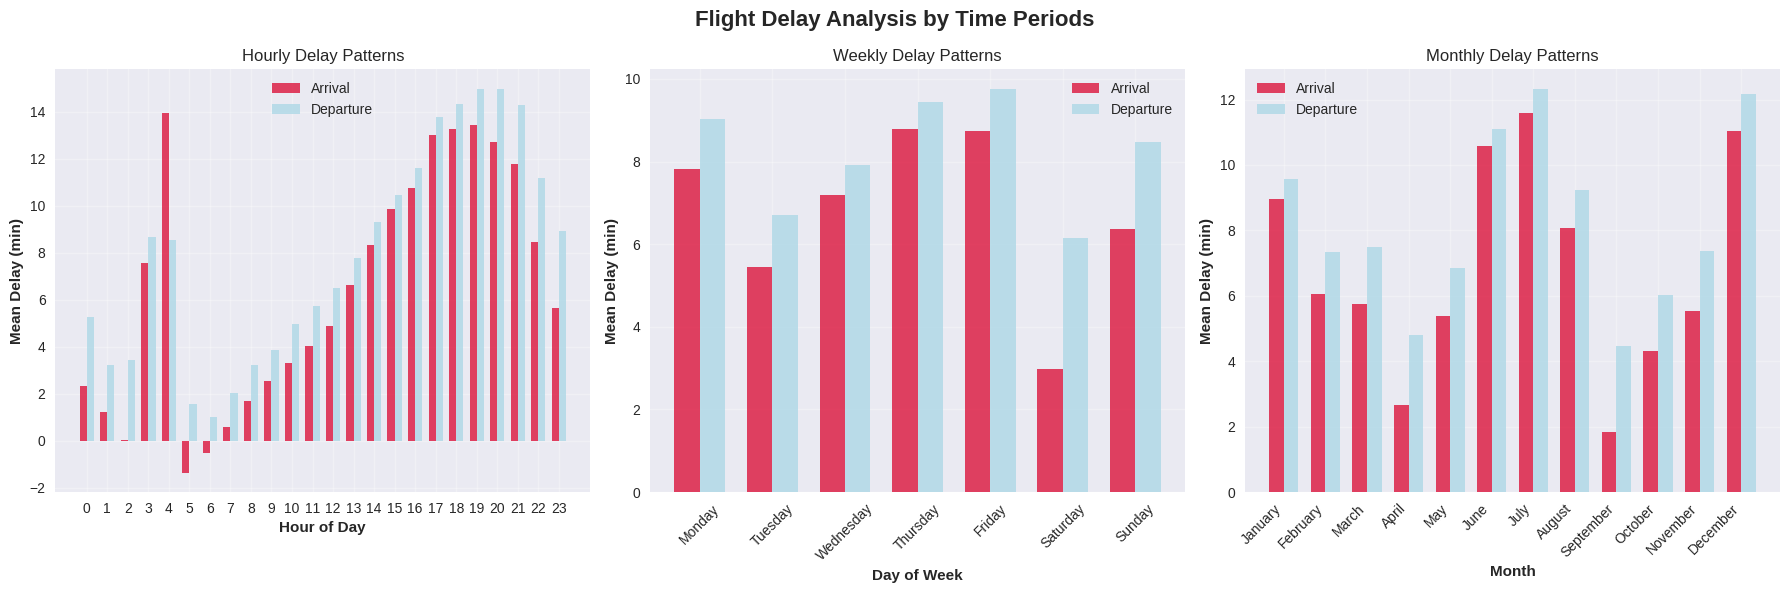

✅ Time analysis plots created with consistent arrival/departure breakdown
   🎯 Best hour (total): 5:00
   🎯 Best day (total): Saturday
   🎯 Best month (total): September

✈️ Plotting Q2: Plane Age Analysis...
✅ Analyzed 47 aircraft manufacturing years (1956-2007)
   🧹 Filtered out 1 invalid years (zeros, negatives, or future dates)


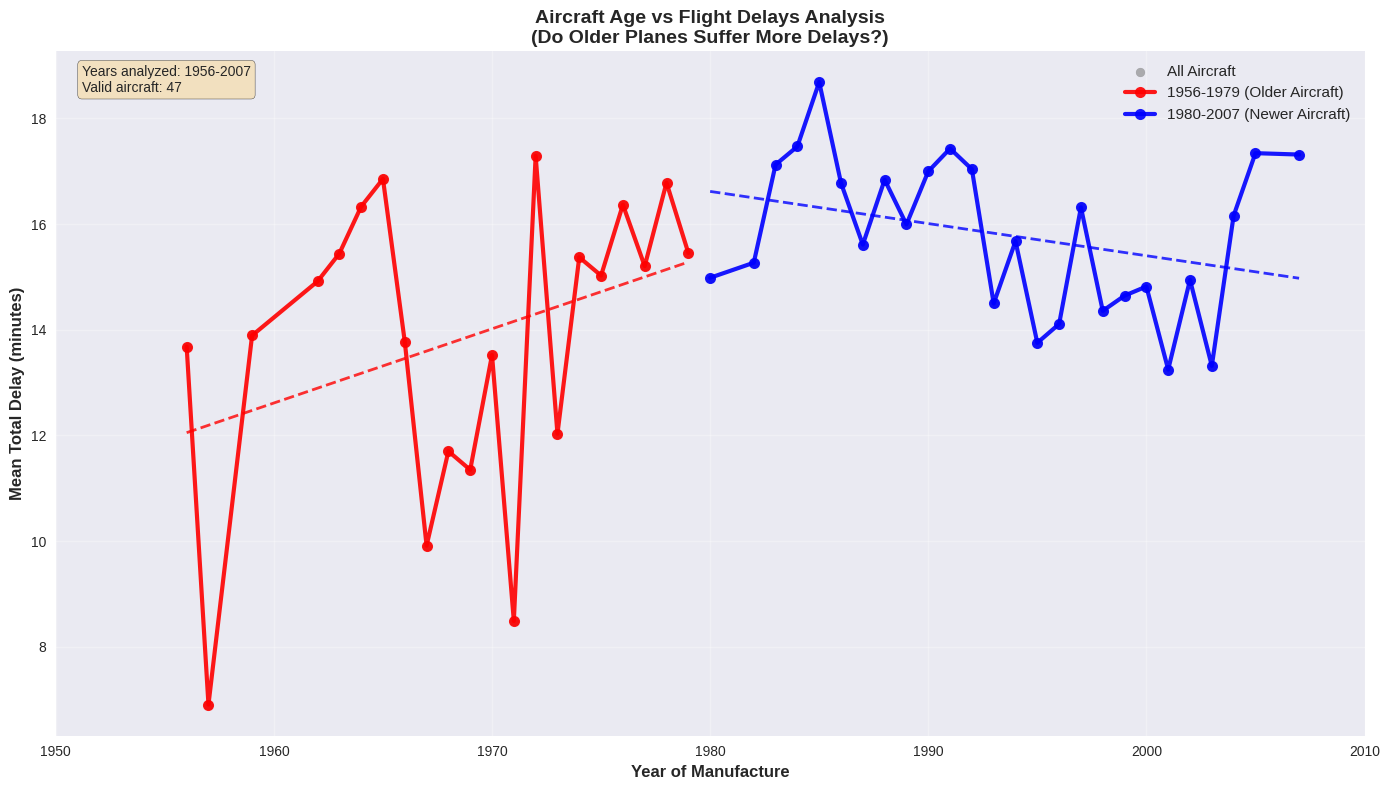


🗺️ Plotting Q3: Flight Connections...


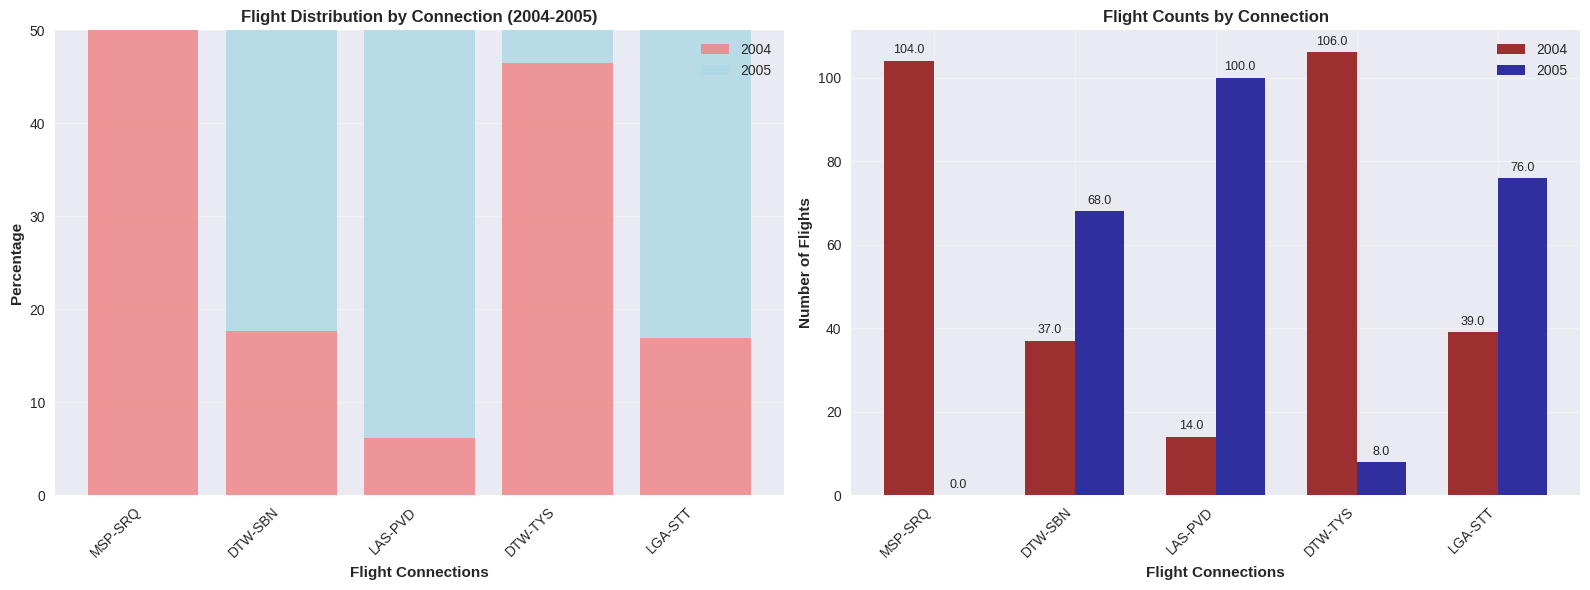

✅ Analyzed 5 flight connections over 2004-2005

🔗 Plotting Q4: Cascading Failures...


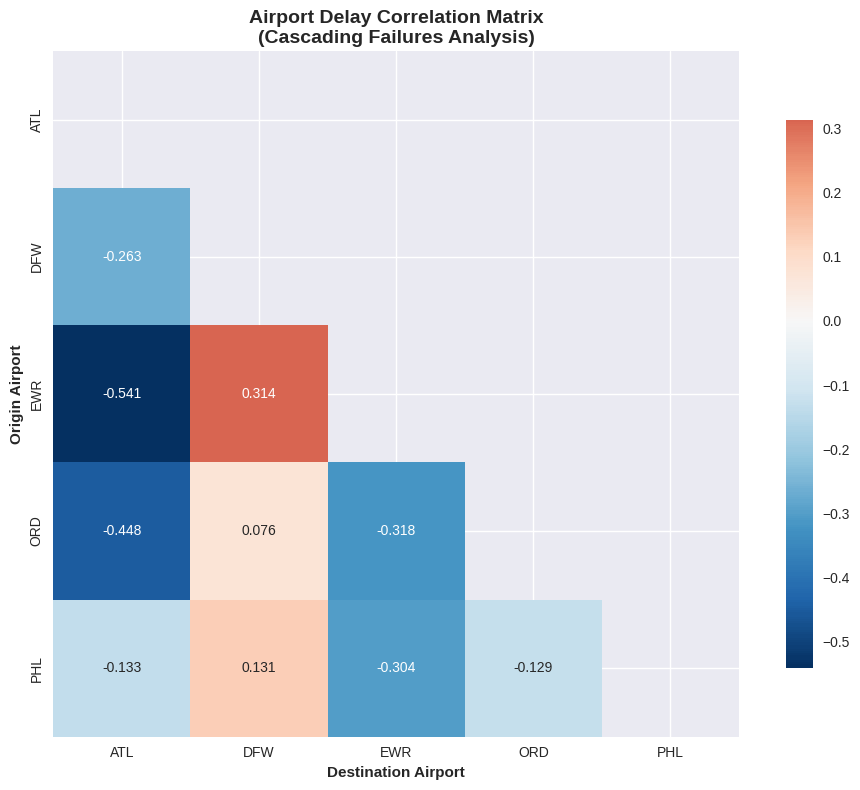

✅ Found 1 strong correlations:
   🔗 ATL ↔ EWR: -0.541

🤖 Plotting Q5: ML Analysis Results...


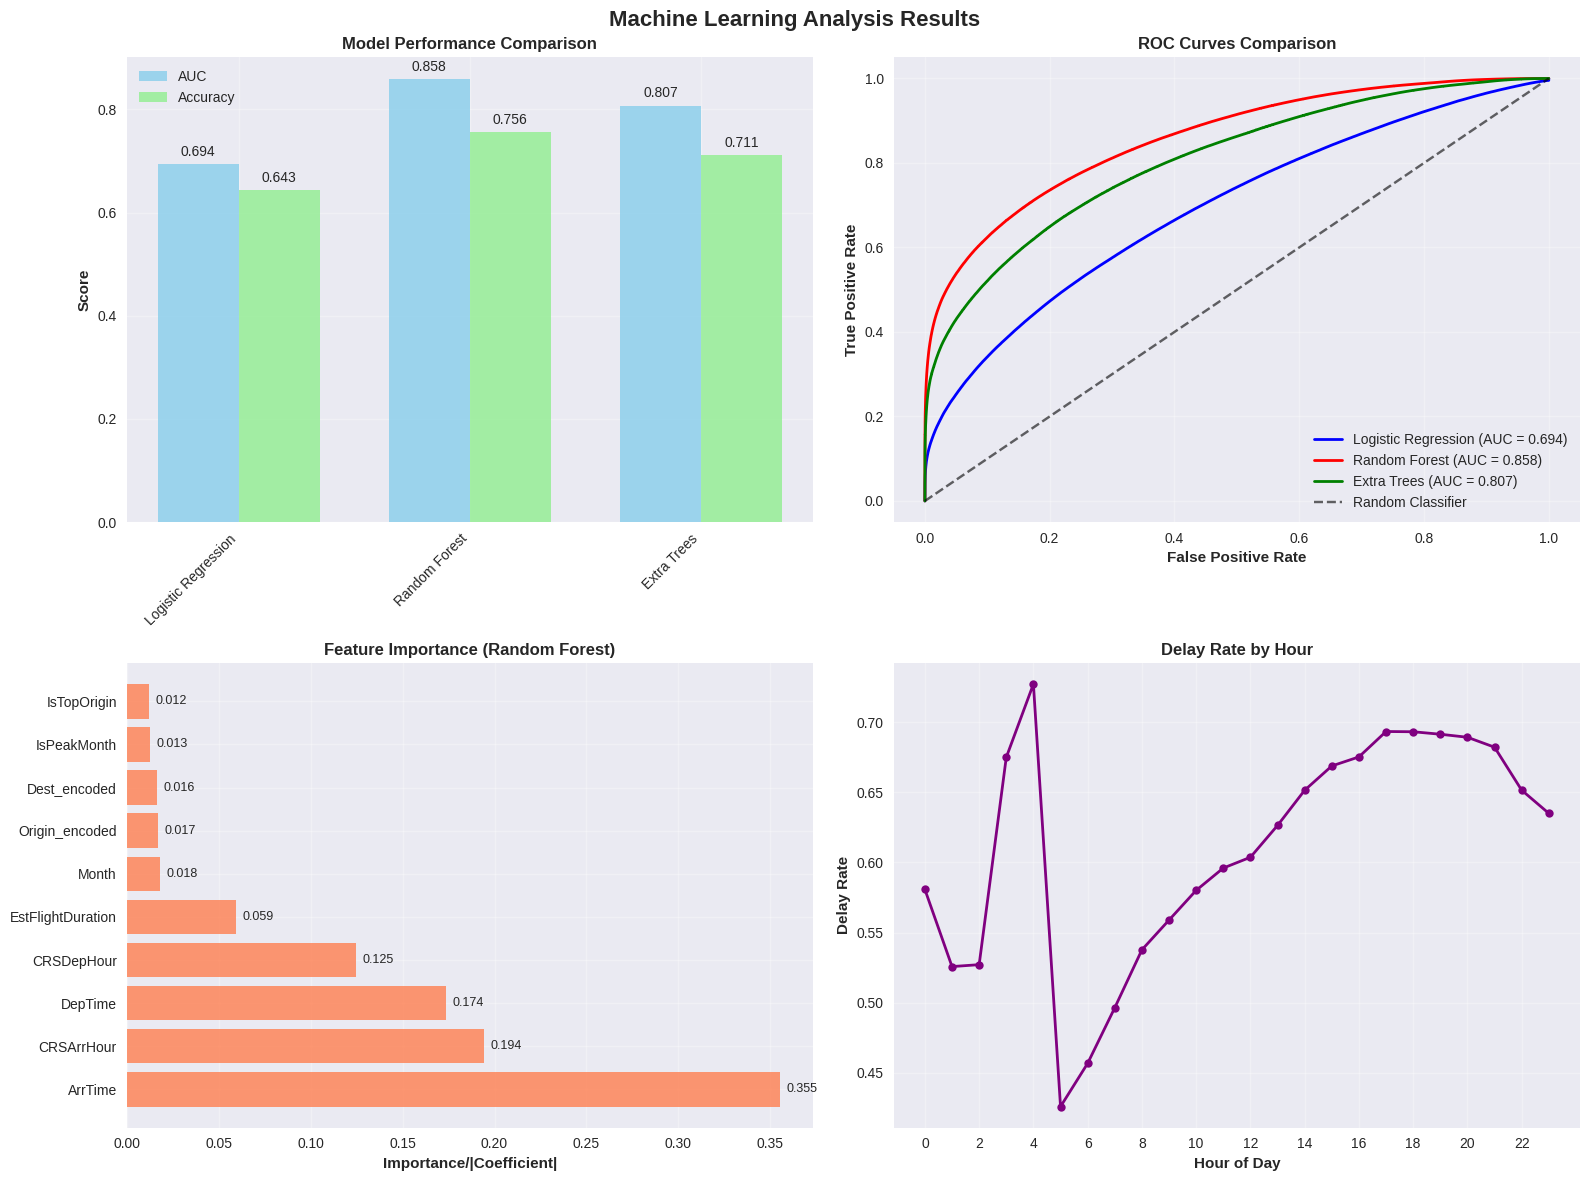

✅ Best Model: Random Forest
   📊 AUC Score: 0.8580
   📈 Sample Size: 9,796,956
   ⏰ Overall Delay Rate: 61.7%

🎉 All fixed plots completed!
✅ Fixes applied:
   • Q2: Properly handles invalid years (0, negative, future)
   • Q2: Uses integer operations for x-axis ticks
   • Q2: Filters data at plotting time for safety
💡 Your JSON data is now plotting correctly!


In [30]:
# 🎯 Run All Fixed Plots
def run_all_fixed_plots():
    """Run all fixed plotting functions"""
    print("🎨 Creating all fixed visualization plots...")
    print("=" * 60)
    
    plot_q1_time_analysis()
    print("\n" + "="*60)
    
    plot_q2_plane_age()
    print("\n" + "="*60)
    
    plot_q3_connections()
    print("\n" + "="*60)
    
    plot_q4_cascading()
    print("\n" + "="*60)
    
    plot_q5_ml_results()
    print("\n" + "="*60)
    
    print("🎉 All fixed plots completed!")
    print("✅ Fixes applied:")
    print("   • Q2: Properly handles invalid years (0, negative, future)")
    print("   • Q2: Uses integer operations for x-axis ticks")
    print("   • Q2: Filters data at plotting time for safety")
    print("💡 Your JSON data is now plotting correctly!")

# Run the fixed plotting
run_all_fixed_plots()

In [31]:
main_df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
Index: 13980567 entries, 0 to 14269865
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Year        int16  
 1   Month       int8   
 2   DayOfWeek   int8   
 3   DepTime     float32
 4   CRSDepTime  int16  
 5   ArrTime     float32
 6   CRSArrTime  int16  
 7   TailNum     object 
 8   ArrDelay    float32
 9   DepDelay    float32
 10  Origin      object 
 11  Dest        object 
dtypes: float32(4), int16(3), int8(2), object(3)
memory usage: 2.8 GB
